## XGBoost Regressor: Default & Tuned

### Imports

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [28]:
#filename = "xgb_tuned.joblib"
#xgb_tuned = joblib.load(filename)

### Preprocessing

In [11]:
# Load data
frag = pd.read_csv("/mnt/project/Transpose/hidra/results/salmon-hidra/batch1/fragment_filtered_fasta/filtered_fragments.fasta", sep="\t", header= None,  names=["fragment_id", "sequence"])

deseq = pd.read_csv("/mnt/project/Transpose/hidra/results/salmon-hidra/batch1/DESeq_TSV/DESeq_res.tsv", sep="\t")

In [11]:
# Clean data for n nucleotides
frag = frag.loc[~frag['sequence'].str.contains('n')].reset_index()
frag.drop("index", axis=1)

deseq = deseq.drop(labels = [2634852, 2634853, 2634854, 2634855, 2634856]).reset_index()
deseq = deseq.drop("index", axis=1)


In [11]:
# Non significant values are given 1 as pvalue and padj

not_sig = {"pvalue": 1, "padj":1}

deseq = deseq.fillna(value=not_sig)

In [11]:
# Concatenating frag and deseq tables to one table
df_all_cols = pd.concat([frag, deseq ], axis = 1)

In [11]:
# Selecting fragments from chromosome 21 and 25 form the table and create a dataframe with only those as test set
chrom_21 = df_all_cols[df_all_cols['fragment'].str.contains('21:')]

chrom_25 = df_all_cols[df_all_cols['fragment'].str.contains('25:')]

test_set = pd.concat([chrom_21, chrom_25], axis = 0)

In [11]:
# Create a training set of all fragments except from chromosome 21 and 25
df_training = df_all_cols.loc[~df_all_cols["fragment"].str.contains('25:') & ~df_all_cols["fragment"].str.contains('21:')].reset_index()
df_training.drop("index", axis=1)

In [11]:
# Select fragments within top 10% basemean for both training and test sets

filtered_frag = df_training[df_training["baseMean"] > 62.609201]

filtered_test = test_set[test_set["baseMean"] > 65.333982]

# Extracting the log2FoldChange values (true values) from training set and test set
y_test = (filtered_test.log2FoldChange)
y = (filtered_frag.log2FoldChange)

### K-mer Encoding

In [12]:
# k_mer function to create k-mer features
# Modified from: k-mer function modified from: https://www.kaggle.com/code/mohdmuttalib/biological-sequence-modeling-with-k-mer-features
def getKmers(sequence, size):
    kmer_seq= [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]
    return ' '.join(kmer_seq)
#from list to string

In [12]:
# Apply k-mer encoding with k-mer sizes from 2 to 6 for each fragment in test set
vectorizer = CountVectorizer()


filtered_test["kmer_2"] = filtered_test["sequence"].apply(lambda x: getKmers(x, size=2))
kmer2test = vectorizer.fit_transform(filtered_test['kmer_2']).astype('float32')
kmer_2test = np.asarray(kmer2test/kmer2test.sum(axis=1))
kmer2_testdf = pd.DataFrame(kmer_2test,columns=['2_mer'] * (4**2))

filtered_test["kmer_3"] = filtered_test["sequence"].apply(lambda x: getKmers(x, size=3))
kmer3test = vectorizer.fit_transform(filtered_test['kmer_3']).astype('float32')
kmer_3test = np.asarray(kmer3test/kmer3test.sum(axis=1))
kmer3_testdf = pd.DataFrame(kmer_3test,columns=['3_mer'] * (4**3))

filtered_test["kmer_4"] = filtered_test["sequence"].apply(lambda x: getKmers(x, size=4))
kmer4test = vectorizer.fit_transform(filtered_test['kmer_4']).astype('float32')
kmer_4test = np.asarray(kmer4test/kmer4test.sum(axis=1))
kmer4_testdf = pd.DataFrame(kmer_4test,columns=['4_mer'] * (4**4))

filtered_test["kmer_5"] = filtered_test["sequence"].apply(lambda x: getKmers(x, size=5))
kmer5test = vectorizer.fit_transform(filtered_test['kmer_5']).astype('float32')
kmer_5test = np.asarray(kmer5test/kmer5test.sum(axis=1))
kmer5_testdf = pd.DataFrame(kmer_5test,columns=['5_mer'] * (4**5))

filtered_test["kmer_6"] = filtered_test["sequence"].apply(lambda x: getKmers(x, size=6))
kmer6test = vectorizer.fit_transform(filtered_test['kmer_6']).astype('float32')
kmer_6test = np.asarray(kmer6test/kmer6test.sum(axis=1))
kmer6_testdf = pd.DataFrame(kmer_6test,columns=['6_mer'] * (4**6))

X_test = pd.concat([kmer2_testdf, kmer3_testdf, kmer4_testdf, kmer5_testdf, kmer6_testdf], axis = 1)

X_test= np.array(X_test)

/home/work/ipykernel_39732/1501980925.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test["kmer_2"] = filtered_test["sequence"].apply(lambda x: getKmers(x, size=2))
/home/work/ipykernel_39732/1501980925.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test["kmer_3"] = filtered_test["sequence"].apply(lambda x: getKmers(x, size=3))
/home/work/ipykernel_39732/1501980925.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [ ]:
# Create k-mer features for training set
vectorizer2 = CountVectorizer()
filtered_frag["kmer_2"] = filtered_frag["sequence"].apply(lambda x: getKmers(x, size=2))
kmer2 = vectorizer2.fit_transform(filtered_frag['kmer_2']).astype('float32')
kmer_2 = np.asarray(kmer2/kmer2.sum(axis=1))
kmer2_df = pd.DataFrame(kmer_2,columns=['2_mer'] * (4**2))
feature_names1 = vectorizer2.get_feature_names_out()


vectorizer3 = CountVectorizer()
filtered_frag["kmer_3"] = filtered_frag["sequence"].apply(lambda x: getKmers(x, size=3))
kmer3 = vectorizer3.fit_transform(filtered_frag['kmer_3']).astype('float32')
kmer_3 = np.asarray(kmer3/kmer3.sum(axis=1))
kmer3_df = pd.DataFrame(kmer_3,columns=['3_mer'] * (4**3))
feature_names2 = vectorizer3.get_feature_names_out()

vectorizer4 = CountVectorizer()
filtered_frag["kmer_4"] = filtered_frag["sequence"].apply(lambda x: getKmers(x, size=4))
kmer4 = vectorizer4.fit_transform(filtered_frag['kmer_4']).astype('float32')
kmer_4 = np.asarray(kmer4/kmer4.sum(axis=1))
kmer4_df = pd.DataFrame(kmer_4,columns=['4_mer'] * (4**4))
feature_names3 = vectorizer4.get_feature_names_out()

vectorizer5 = CountVectorizer()
filtered_frag["kmer_5"] = filtered_frag["sequence"].apply(lambda x: getKmers(x, size=5))
kmer5 = vectorizer5.fit_transform(filtered_frag['kmer_5']).astype('float32')
kmer_5 = np.asarray(kmer5/kmer5.sum(axis=1))
kmer5_df = pd.DataFrame(kmer_5,columns=['5_mer'] * (4**5))
feature_names4 = vectorizer5.get_feature_names_out()

vectorizer6 = CountVectorizer()
filtered_frag["kmer_6"] = filtered_frag["sequence"].apply(lambda x: getKmers(x, size=6))
kmer6 = vectorizer6.fit_transform(filtered_frag['kmer_6']).astype('float32')
kmer_6 = np.asarray(kmer6/kmer6.sum(axis=1))
kmer6_df = pd.DataFrame(kmer_6,columns=['6_mer'] * (4**6))
feature_names5 = vectorizer6.get_feature_names_out()


X = pd.concat([kmer2_df, kmer3_df, kmer4_df, kmer5_df, kmer6_df], axis = 1)


In [ ]:
# Save the feature names to use for feature importance
feature_names = []
feature_names.extend(feature_names1)
feature_names.extend(feature_names2)
feature_names.extend(feature_names3)
feature_names.extend(feature_names4)
feature_names.extend(feature_names5)



In [ ]:
# Feature names as list 
X_names = list(X.columns)

X = np.array(X)

In [ ]:
# Train, validation split
X_train,X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state = 42)

### Default Model

In [ ]:
# Train model xgboost regressor with default parameter
clf_xgboost = xgb.XGBRegressor(objective="reg:squarederror",random_state=42)

# Train the model 

clf_xgboost.fit(X_train, y_train)


In [ ]:

# Get predictions
y_pred = clf_xgboost.predict(X_valid)

# Calculatig rmse
rmse_pred = mean_squared_error(y_valid, y_pred) 

print("Root Mean Squared Error, validation:" , np.sqrt(rmse_pred))

print("R2 score validation:" , r2_score(y_valid, y_pred))


In [ ]:
# Predictions on test set 
y_pred_test = clf_xgboost.predict(X_test)

# Calculatig root mean squared error
rmse_pred_test = mean_squared_error(y_test, y_pred_test) 

print("Root Mean Squared Error, test:" , np.sqrt(rmse_pred_test))

print("R2 score test:", r2_score(y_test, y_pred_test))

### Hyperparametertuning

In [2]:
# Create a model
xgboost = xgb.XGBRegressor(objective="reg:squarederror",random_state=42)

#parameters for tuning
#inspired by: https://github.com/yvasandvik/data-science-thesis/blob/master/method/xgb-tuning-model.ipynb
params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), 
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150)
}
#randomized search
xgb_random = RandomizedSearchCV(xgboost, param_distributions=params, random_state=42, n_iter=10, cv=3, verbose=1, n_jobs=-1, return_train_score=True)

# Train the model 
xgb_random.fit(X_train, y_train)

NameError: name 'xgb' is not defined

In [ ]:
# Get predictions
y_pred = xgb_tuned.predict(X_valid)

# Calculatig root mean squared error
rmse_pred = mean_squared_error(y_valid, y_pred) 

print("Root Mean Absolute Error:" , np.sqrt(rmse_pred))

print("R2 score:" , r2_score(y_valid, y_pred))


In [30]:
# Predictions on test set 
y_pred_test = xgb_tuned.predict(X_test)

print("R2 score test:" ,r2_score(y_test, y_pred_test))

rmse_pred_test = mean_squared_error(y_test, y_pred_test) 

print("Root Mean Squared Error:" , np.sqrt(rmse_pred_test))
 

R2 score test: 0.28263549814602673
Root Mean Absolute Error: 0.49063256758324186


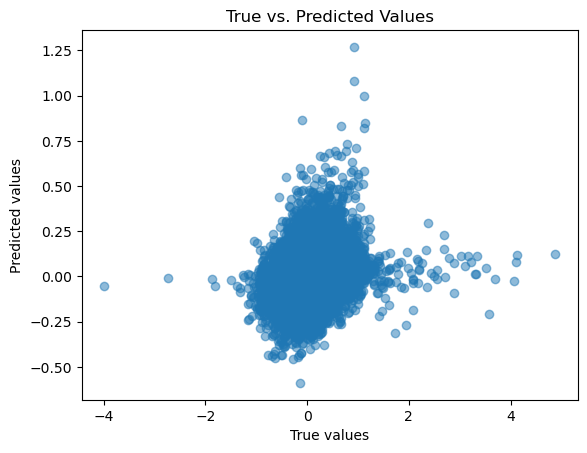

In [29]:
#### print(np.corrcoef(y_test,y_pred_test))

r = np.corrcoef(y_test.T, y_pred_test.T)[0, 1]

# Plot the true vs predicted values with some customizations
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs. Predicted Values')
plt.savefig("xgb_tunednormal.png")
plt.show()

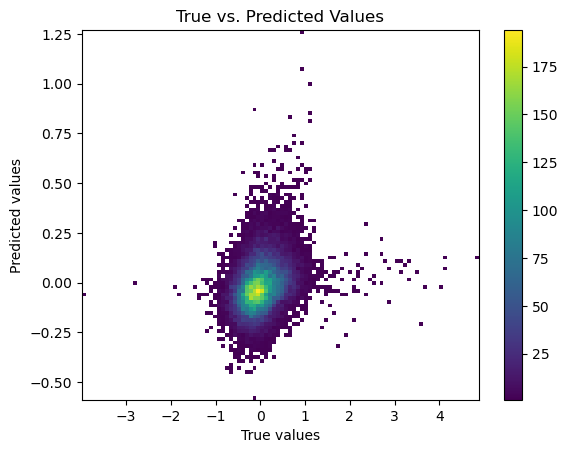

In [27]:

# Set the facecolor of the figure to white
fig = plt.figure(facecolor='w')

# Create a scatter histogram
plt.hist2d(y_test, y_pred_test, bins=100, cmap='viridis',cmin=1)
plt.colorbar()

plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs. Predicted Values')
plt.savefig("xgbtuned.png")
# Show the plot
plt.show()


### Learning Curve

In [ ]:
# Define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_valid,y_valid)]

# Fit the model
xgb_tuned.fit(X_train, y_train, eval_metric='rmse', eval_set=evalset, verbose=False)

# Evaluate performance
yhat = xgb_tuned.predict(X_valid)
score = mean_squared_error(y_valid, yhat)
print('MSE: %.3f' % score)

# Retrieve performance metrics
results = clf_xgboost.evals_result()

# Plot the learning curve
plt.plot(results['validation_0']['rmse'], label='Training')
plt.plot(results['validation_1']['rmse'], label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBRegressor Learning Curve')
plt.legend()
plt.savefig("xgb_val.png")
plt.show()

### Feature Selection

In [ ]:
# Select features


X_train,X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state = 42)

f_imp = pd.Series(.feature_importances_, index = X_names).sort_values(ascending=False)

select= f_imp.iloc[0:200]

selected_feat = list(select.index)


# Select most important features
important_indices = [X_names.index(feat) for feat in selected_feat]

imp_train = X_train[:, important_indices]
imp_valid = X_valid[:, important_indices]
imp_test = X_test[:, important_indices]



# Train the model 
xgb_tuned.fit(imp_train, y_train)


# Get predictions
y_pred_imp = xgb_tuned.predict(imp_valid)

# Calculatig root mean absolute error
rmse_pred_imp = mean_absolute_error(y_valid, y_pred_imp) 

print("Root Mean Absolute Error:" , np.sqrt(rmse_pred_imp))

print("R2 score:" , r2_score(y_valid, y_pred_imp))


# Predictions on test set 
y_pred_testimp = xgb_tuned.predict(imp_test)

print(r2_score(y_test, y_pred_testimp))

print(np.corrcoef(y_test,y_pred_testimp))